In [13]:
%matplotlib inline
%load_ext tensorboard
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,Input,BatchNormalization,Flatten,MaxPooling2D,Activation,Dropout,concatenate,Softmax
from tensorflow.keras.models import Model,Sequential 
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
#!tar -xvf /content/drive/MyDrive/Assignment/images.tar

In [ ]:
#!unzip /content/drive/MyDrive/Assignment/dog-breed-identification.zip

In [ ]:
"""
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

var colab = setInterval(ConnectButton,60000);
"""

In [ ]:
rootDir = 'Images/'
for i in tqdm(os.listdir(rootDir)):
  old_name = rootDir+i
  lower_i = i.lower()
  new_name = rootDir+lower_i
  os.rename(old_name, new_name)

100%|██████████| 120/120 [00:00<00:00, 46599.06it/s]


In [ ]:
train_data_dir = "Images/"
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2)

valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

In [ ]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    batch_size= 64,  
    subset='training',
    shuffle= True, 
    class_mode= 'categorical',
    target_size= (331, 331), 
    color_mode= 'rgb',
    seed= 42) 

Found 16508 images belonging to 120 classes.


In [ ]:
valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    batch_size= 64,  
    subset='validation',
    shuffle= True, 
    class_mode= 'categorical',
    target_size= (331, 331),
    color_mode= 'rgb',
    seed= 42
)

Found 4072 images belonging to 120 classes.


In [ ]:
IMG_HEIGHT = 331
IMG_WIDTH = 331

model_inception_resnet_v2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))

model_nasnet = tf.keras.applications.nasnet.NASNetLarge(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))

model_inception_resnet_v2.trainable = False
model_nasnet.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x1 = model_inception_resnet_v2(inputs, training=False)
x1 = GlobalAveragePooling2D()(x1)

x2 = model_nasnet(inputs, training=False)
x2 = GlobalAveragePooling2D()(x2)

x = Concatenate()([x1, x2])
x = Dropout(.7)(x)
outputs = Dense(120, activation='softmax')(x)
model = Model(inputs, outputs)

display(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_resnet_v2 (Functiona  (None, 9, 9, 1536)  54336736    ['input_3[0][0]']                
 l)                                                                                               
                                                                                                  
 NASNet (Functional)            (None, 11, 11, 4032  84916818    ['input_3[0][0]']                
                                )                                                             

None

In [ ]:
indices = train_generator.class_indices

In [ ]:
labels = dict()
for k,v in indices.items():
  labels[k.split('-')[1]] = v

In [ ]:
import joblib
root_dir = '/content/drive/MyDrive/self_case_study/debun/'
joblib.dump(labels, root_dir+'labels.pkl')

['/content/drive/MyDrive/self_case_study/debun/labels.pkl']

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7,mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', min_lr=0.0000001,patience=2)

root_dir = '/content/drive/MyDrive/self_case_study/debun'
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(root_dir+"model_ensemble_history_log_stanford_data.csv", append=True,separator=",")

checkpoint = ModelCheckpoint(root_dir+'model_ensemble_weights_stanford_data.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy')

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=50, callbacks = [earlystopping, reduce_lr, csv_logger, checkpoint])

Epoch 1/50
257/257 [==============================] - 889s 3s/step - loss: 2.8930 - accuracy: 0.5919 - val_loss: 1.1685 - val_accuracy: 0.9340 - lr: 1.0000e-04
Epoch 2/50
257/257 [==============================] - 844s 3s/step - loss: 0.8370 - accuracy: 0.8942 - val_loss: 0.4199 - val_accuracy: 0.9377 - lr: 1.0000e-04
Epoch 3/50
257/257 [==============================] - 846s 3s/step - loss: 0.4610 - accuracy: 0.9104 - val_loss: 0.2844 - val_accuracy: 0.9390 - lr: 1.0000e-04
Epoch 4/50
257/257 [==============================] - 844s 3s/step - loss: 0.3499 - accuracy: 0.9187 - val_loss: 0.2362 - val_accuracy: 0.9415 - lr: 1.0000e-04
Epoch 5/50
257/257 [==============================] - 843s 3s/step - loss: 0.3110 - accuracy: 0.9172 - val_loss: 0.2144 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 6/50
257/257 [==============================] - 844s 3s/step - loss: 0.2794 - accuracy: 0.9250 - val_loss: 0.2035 - val_accuracy: 0.9422 - lr: 1.0000e-04
Epoch 7/50
257/257 [====================

In [ ]:
history = pd.read_csv(root_dir+"model_ensemble_history_log_stanford_data.csv")

In [ ]:
def plot_performance_metric(history):
  # Plot training & validation iou_score values
  plt.figure(figsize=(30, 5))
  plt.subplot(121)
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  # Plot training & validation loss values
  plt.subplot(122)
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

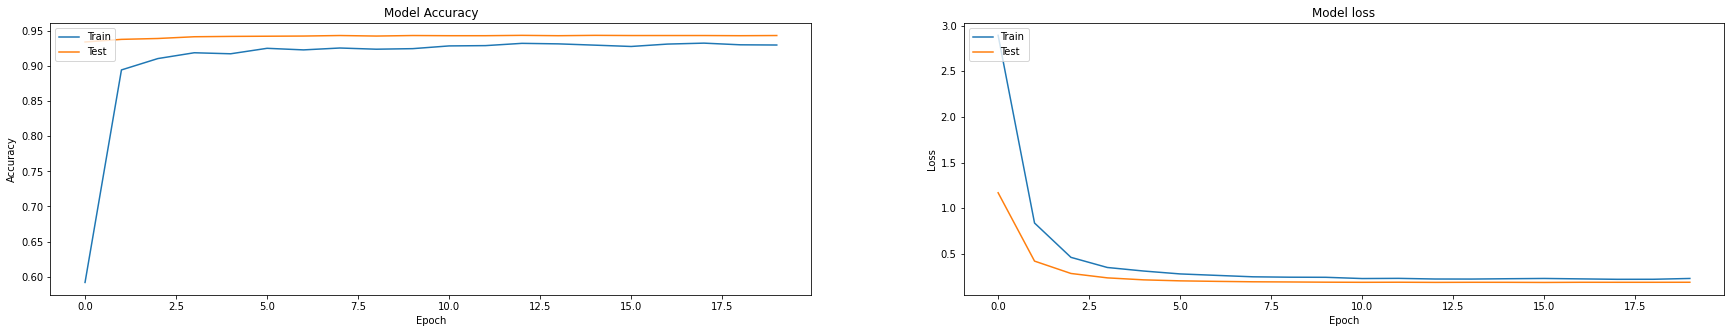

In [ ]:
plot_performance_metric(history)

In [ ]:
breed = []
for i in indices.keys():
  breed.append(i.split('-')[1])

In [ ]:
#!unzip /content/drive/MyDrive/Assignment/dog-breed-identification.zip

In [ ]:
root_dir = '/content/drive/MyDrive/self_case_study/debun'
filepath=root_dir+'model_ensemble_weights_stanford_data.h5'
model.load_weights(filepath)

In [ ]:
model.save(root_dir+'/model_ensemble_weights_stanford_data.h5')

In [15]:
root_dir = '/content/drive/MyDrive/self_case_study/debun/'
model = tf.keras.models.load_model(root_dir+'model_ensemble_weights_stanford_data.h5')

In [ ]:
import shutil
os.makedirs("root/data/test/")
for i in tqdm(range(len(os.listdir('test')))):
    dir = os.listdir('test')[i]
    source = "test/"+dir

    # Destination path
    destination = "root/data/test/"
    shutil.copy(source, destination)

100%|██████████| 10357/10357 [00:54<00:00, 188.73it/s]


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
        'root/data/',
        target_size=(331, 331),
        batch_size=64,
        class_mode=None,
        shuffle=False)

Found 10357 images belonging to 1 classes.


In [24]:
import os
a = os.listdir("Images")[0]
os.makedirs('test_root/test')

In [ ]:
prediction = model.predict(test_data)

In [ ]:
id = []
for i in sorted(os.listdir('test')):
  id.append(i.split('.')[0])

In [ ]:
data = pd.read_csv("labels.csv")
data['path'] = data['id'].values+'.jpg'
data.head()

,id,breed,path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg


In [ ]:
df = pd.DataFrame(columns=breed)
for i in tqdm(range(10357)):
  row = []
  #row.append(id[i])
  for x in prediction[i]:
    row.append(x)
  df.loc[len(df.index)] = row

100%|██████████| 10357/10357 [00:19<00:00, 543.00it/s]


In [ ]:
submission = pd.DataFrame(columns=['id'])
submission['id'] = id
for i in sorted(np.unique(data['breed'])):
  submission[i] = df[i]

In [ ]:
submission = pd.DataFrame(columns=['id']+sorted(np.unique(data['breed'])))

for i in tqdm(range(10357)):
  row = []
  row.append(id[i])
  
  for x in prediction[i]:
    row.append(x)
  submission.loc[len(submission.index)] = row

100%|██████████| 10357/10357 [01:49<00:00, 94.71it/s]


In [ ]:
submission.to_csv('model_ensemble_2.4_stanford_data.csv',index=False)

In [17]:
os.makedirs('root/test')

In [18]:
import shutil
source = '/content/4366ae84914916e5e60738e0d1d3846e.jpg'
shutil.move(source,'root/test/test_img.jpg')

'root/test/test_img.jpg'

In [21]:
import joblib
def function1(image_dir):
          test_datagen = ImageDataGenerator(rescale=1./255)
          test_data = test_datagen.flow_from_directory(
                  image_dir,
                  target_size=(331, 331),
                  batch_size=64,
                  class_mode=None,
                  shuffle=False)
          labels = joblib.load('/content/drive/MyDrive/self_case_study/debun/labels.pkl')
          #model = joblib.load('C://Users//Debasish Pradhan//.spyder-py3//Deployment//pkl_files//debunfinal_model.pkl')
          model = tf.keras.models.load_model('/content/drive/MyDrive/self_case_study/debun/model_ensemble_weights_stanford_data.h5')

          prediction = model.predict(test_data)
          predicted_class = np.argmax(prediction[0])
          #print('hhhhhhhhhhh',predicted_class)
          output = [key for key,value in labels.items() if value==predicted_class][0]
          return f"Given Dog's breed is {output}"
      
output = function1('root')
output

Found 1 images belonging to 1 classes.


"Given Dog's breed is airedale"